### Drive Mounting

In [ ]:
from google.colab import drive
drive.mount('./MyDrive')

Drive already mounted at ./MyDrive; to attempt to forcibly remount, call drive.mount("./MyDrive", force_remount=True).


In [ ]:
cd MyDrive/My Drive/Colab Notebooks/project

/content/MyDrive/My Drive/Colab Notebooks/project


### Package Loading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchvision import transforms
from torchvision.datasets import STL10
from torchsummary import summary

from tqdm.notebook import tqdm
import time

### Parameter Setting

In [ ]:
class Config:
    seed = 42
    device = "cuda"if torch.cuda.is_available() else 'cpu'

    epochs = 125
    epochs_fine_training = 25
    batch_size = 25
    n_classes = 10

    lambd = 3
    dim_noise = 100
    image_size = (3, 64, 64)

    lr = 0.0002
    beta1 = 0.5

    t_path = "./checkpoint/meta_pseudo_labels(same)/Teacher(Xception).pt"
    s_path = "./checkpoint/meta_pseudo_labels(same)/Student(Xception).pt"
    s_fine_training_path = "./checkpoint/meta_pseudo_labels(same)/Student_fine_trained(Xception).pt"

    history_path = "./history/meta_pseudo_labels(same)/history(Xception).csv"
    history_fine_training_path = "./history/meta_pseudo_labels(same)/history_fine_training(Xception).csv"

print(Config.device)

cuda


In [ ]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = True 

In [ ]:
seed_everything(Config.seed)

### Data Loading

In [ ]:
transform = transforms.Compose([transforms.RandomCrop((64, 64)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

In [ ]:
train_ds = STL10('./data', split='train', download=True, transform=transform)
unlabeled_ds = STL10('./data', split='unlabeled', download=True, transform=transform)
test_ds = STL10('./data', split='test', download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_set, valid_set = random_split(train_ds, [4000, 1000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


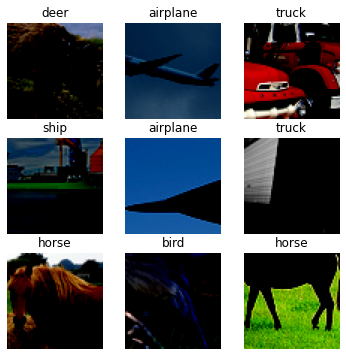

In [ ]:
figure = plt.figure(figsize=(6, 6))

classes = ('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

In [ ]:
print("labeld size: %d" % (len(train_set)))
print("unlabeld size: %d" % (len(unlabeled_ds)))
print("validation size: %d" % (len(valid_set)))
print("test size: %d" % (len(test_ds)))

labeld size: 4000
unlabeld size: 100000
validation size: 1000
test size: 8000


In [ ]:
labeled_dl = DataLoader(train_set, batch_size=Config.batch_size, shuffle=True)
unlabeled_dl = DataLoader(unlabeled_ds, batch_size=len(train_set), shuffle=True)
valid_dl = DataLoader(valid_set, batch_size=Config.batch_size,)
test_dl = DataLoader(test_ds, batch_size=Config.batch_size)

### Model Defining

In [ ]:
class ConvWithBN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvWithBN, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, inputs):
        outputs = self.layers(inputs)

        return outputs

In [ ]:
class SeparableConvWithBN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SeparableConvWithBN, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, groups=in_channels, bias=False),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, inputs):
        outputs = self.layers(inputs)
        
        return outputs

In [ ]:
class ShortcutProjectionWithBN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ShortcutProjectionWithBN, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, inputs):
        outputs = self.layers(inputs)

        return outputs

In [ ]:
class EntryFlow(nn.Module):
    def __init__(self):
        super(EntryFlow, self).__init__()

        self.block_1 = nn.Sequential(
            ConvWithBN(3, 32),
            nn.ReLU(),
            ConvWithBN(32, 64),
            nn.ReLU()
        )

        self.block_2 = nn.Sequential(
            SeparableConvWithBN(64, 128),
            nn.ReLU(),
            SeparableConvWithBN(128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.block_2_shortcut = ShortcutProjectionWithBN(64, 128)

        self.block_3 = nn.Sequential(
            nn.ReLU(),
            SeparableConvWithBN(128, 256),
            nn.ReLU(),
            SeparableConvWithBN(256, 256),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.block_3_shortcut = ShortcutProjectionWithBN(128, 256)

        self.block_4 = nn.Sequential(
            nn.ReLU(),
            SeparableConvWithBN(256, 728),
            nn.ReLU(),
            SeparableConvWithBN(728, 728),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.block_4_shortcut = ShortcutProjectionWithBN(256, 728)

    def forward(self, inputs):
        x = self.block_1(inputs)
        x = self.block_2(x) + self.block_2_shortcut(x)
        x = self.block_3(x) + self.block_3_shortcut(x)
        outputs = self.block_4(x) + self.block_4_shortcut(x)
        
        return outputs

In [ ]:
class MiddleFlow(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.ReLU(),
            SeparableConvWithBN(728, 728),
            nn.ReLU(),
            SeparableConvWithBN(728, 728),
            nn.ReLU(),
            SeparableConvWithBN(728, 728),
        )

    def forward(self, inputs):
        outputs = self.layers(inputs) + inputs

        return outputs

In [ ]:
class ExitFlow(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.ReLU(),
            SeparableConvWithBN(728, 728),
            nn.ReLU(),
            SeparableConvWithBN(728, 1024),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.block_1_shortcut = ShortcutProjectionWithBN(728, 1024)

        self.block_2 = nn.Sequential(
            SeparableConvWithBN(1024, 1536),
            nn.ReLU(),
            SeparableConvWithBN(1536, 2048),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 4, stride = 1),
        )
    
    def forward(self, inputs):
        x = self.block_1(inputs) + self.block_1_shortcut(inputs)
        outputs = self.block_2(x)

        return outputs

In [ ]:
class Xception(nn.Module):
    def __init__(self, n_classes):
        super(Xception, self).__init__()

        self.entry_flow = EntryFlow()
        self.middle_flow = self.make_middle_flow()
        self.exit_flow = ExitFlow() 

        self.classifier = nn.Sequential(
          nn.Dropout(p=0.5),
          nn.Linear(2048, n_classes)
        )

        self.initialize_weights()

    def make_middle_flow(self):
        outputs = []

        for i in range(8):
            outputs.append(MiddleFlow())

        return nn.Sequential(*outputs)

    def initialize_weights(self):
      for i in self.modules():
        if isinstance(i, nn.Conv2d):
            nn.init.kaiming_normal_(i.weight, mode='fan_in', nonlinearity='relu')
        elif isinstance(i, nn.Linear):
            nn.init.kaiming_normal_(i.weight, mode='fan_in', nonlinearity='relu')
            nn.init.constant_(i.bias, 0)

    def forward(self, inputs):
      x = self.entry_flow(inputs)
      x = self.middle_flow(x)
      x = self.exit_flow(x)
      x = x.view(x.shape[0], -1)
      outputs = self.classifier(x)
        
      return outputs

In [ ]:
t_model = Xception(n_classes=Config.n_classes).to(Config.device)

summary(t_model, input_size = (Config.image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
        ConvWithBN-3           [-1, 32, 64, 64]               0
              ReLU-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,432
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        ConvWithBN-7           [-1, 64, 64, 64]               0
              ReLU-8           [-1, 64, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]             576
           Conv2d-10          [-1, 128, 64, 64]           8,192
      BatchNorm2d-11          [-1, 128, 64, 64]             256
SeparableConvWithBN-12          [-1, 128, 64, 64]               0
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 12

In [ ]:
s_model = Xception(n_classes=Config.n_classes).to(Config.device)

summary(s_model, input_size = (Config.image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
        ConvWithBN-3           [-1, 32, 64, 64]               0
              ReLU-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,432
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        ConvWithBN-7           [-1, 64, 64, 64]               0
              ReLU-8           [-1, 64, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]             576
           Conv2d-10          [-1, 128, 64, 64]           8,192
      BatchNorm2d-11          [-1, 128, 64, 64]             256
SeparableConvWithBN-12          [-1, 128, 64, 64]               0
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 12

### Training Setting

In [ ]:
cross_entropy = nn.CrossEntropyLoss(reduction='mean')

t_optimizer = optim.Adam(t_model.parameters(), lr=Config.lr, betas=(Config.beta1, 0.999))
s_optimizer = optim.Adam(s_model.parameters(), lr=Config.lr, betas=(Config.beta1, 0.999))

In [ ]:
def meta_pseudo_labels(t_model, s_model, t_optimizer, s_optimizer, lambd, epochs, t_path, s_path, history_path, labeled_dl, unlabeled_dl, valid_dl):
    history = {'T_loss':[], 'S_loss':[], 'S_valid_acc':[]}        
    start_time = time.time()
    current_label_epoch = 0;
      
    for unlabel_iter in range(int(epochs/len(unlabeled_dl))): 
        for unlabeled_batch, _ in unlabeled_dl:
            epoch_time = time.time()

            total_T_loss = 0
            total_S_loss = 0

            s_model.train()
            for (labeled_inputs, labels), i in tqdm(zip(labeled_dl, range(len(labeled_dl))), total=len(labeled_dl), desc="Training", leave=False):
                labeled_inputs, labels = labeled_inputs.to(Config.device), labels.to(Config.device)
                unlabeled_inputs = unlabeled_batch[i*Config.batch_size:(i+1)*Config.batch_size].to(Config.device)
       
                t_unlabeled_outputs = t_model(unlabeled_inputs)
                _, pseudo_labels = torch.max(t_unlabeled_outputs.detach().data, 1)
                
                # Train s_model
                s_optimizer.zero_grad()

                s_unlabeled_outputs = s_model(unlabeled_inputs)
                s_labeled_outputs_old = s_model(labeled_inputs)

                s_cross_entropy_unlabeled = cross_entropy(s_unlabeled_outputs, pseudo_labels)

                s_loss = s_cross_entropy_unlabeled
                s_loss.backward(retain_graph=True)
                s_optimizer.step()

                total_S_loss += s_loss.item()

                # Train t_model      
                t_optimizer.zero_grad()

                t_labeled_outputs = t_model(labeled_inputs)

                t_cross_entropy_unlabeled = cross_entropy(t_unlabeled_outputs, pseudo_labels)
                t_cross_entropy_labeled = cross_entropy(t_labeled_outputs, labels) 

                s_labeled_outputs_new = s_model(labeled_inputs)
                s_cross_entropy_labeled_old = cross_entropy(s_labeled_outputs_old.detach(), labels)
                s_cross_entropy_labeled_new = cross_entropy(s_labeled_outputs_new.detach(), labels)
                coefficient_from_s = s_cross_entropy_labeled_old - s_cross_entropy_labeled_new

                t_loss = (coefficient_from_s * t_cross_entropy_unlabeled) + (lambd * t_cross_entropy_labeled)
                t_loss.backward(retain_graph=True)
                t_optimizer.step()

                total_T_loss += t_loss.item()

            T_loss = total_T_loss / len(labeled_dl)
            S_loss = total_S_loss / len(labeled_dl)

            history['T_loss'].append(T_loss)
            history['S_loss'].append(S_loss)

            valid_total = 0
            valid_correct = 0

            s_model.eval()
            with torch.no_grad():
              for inputs, labels in tqdm(valid_dl, desc="Validation", leave=False):
                  inputs, labels = inputs.to(Config.device), labels.to(Config.device)
                  outputs = s_model(inputs)
                  _, predicted = torch.max(outputs.data, 1)

                  valid_total += labels.size(0)
                  valid_correct += (predicted == labels).sum().item()

            valid_acc = valid_correct / valid_total * 100

            history['S_valid_acc'].append(valid_acc)

            torch.save(t_model.state_dict(), t_path)
            torch.save(s_model.state_dict(), s_path)

            current_label_epoch += 1
            tqdm.write('[Epoch : %d/%d] T_loss: %.5f, S_loss: %.5f, S_valid_acc: %.2f, elapsed_time_in_epoch: %02d:%02d' % (current_label_epoch, epochs, T_loss, S_loss, valid_acc, (time.time()-epoch_time)/60, (time.time()-epoch_time)%60))

    print('Finished training')
    print('Total elapsed time: %02d:%02d' % ((time.time()-start_time)/60, (time.time()-start_time)%60))

    history_df = pd.DataFrame(history)
    history_df.to_csv(history_path)

    return t_model, s_model, history

In [ ]:
def fine_training(model, optimizer, epochs, model_path, history_path, train_dl, valid_dl):
    history = {'train_loss':[], 'valid_acc':[]}        
    start_time = time.time()
      
    for epoch in range(epochs): 
        epoch_time = time.time()

        train_losses = 0

        valid_total = 0
        valid_correct = 0

        model.train()
        for inputs, labels in tqdm(train_dl, desc="Training", leave=False):
                inputs, labels = inputs.to(Config.device), labels.to(Config.device)
                optimizer.zero_grad()

                outputs = model(inputs)
                cross_entropy_loss = cross_entropy(outputs, labels)

                loss = cross_entropy_loss
                loss.backward(retain_graph=True)
                optimizer.step()

                train_losses += loss.item()

        train_loss = train_losses / len(train_dl)
        history['train_loss'].append(train_loss)

        model.eval()
        with torch.no_grad():
          for inputs, labels in tqdm(valid_dl, desc="Validation", leave=False):
              inputs, labels = inputs.to(Config.device), labels.to(Config.device)

              outputs = model(inputs)
              _, predicted = torch.max(outputs.data, 1)

              valid_total += labels.size(0)
              valid_correct += (predicted == labels).sum().item()

        valid_acc = valid_correct / valid_total * 100
        history['valid_acc'].append(valid_acc)

        tqdm.write('[Epoch : %d/%d] train_loss: %.5f, valid_acc: %.2f, elapsed_time_in_epoch: %02d:%02d' % (epoch + 1, epochs, train_loss, valid_acc, (time.time()-epoch_time)/60, (time.time()-epoch_time)%60))

        torch.save(model.state_dict(), model_path)

    print('Finished training')
    print('Total elapsed time: %02d:%02d' % ((time.time()-start_time)/60, (time.time()-start_time)%60))

    history_df = pd.DataFrame(history)
    history_df.to_csv(history_path)

    return model, history

### Meta Pseudo Labels

In [ ]:
t_model, s_model, history = meta_pseudo_labels(t_model, s_model, t_optimizer, s_optimizer, Config.lambd, Config.epochs, Config.t_path, Config.s_path, Config.history_path, labeled_dl, unlabeled_dl, valid_dl)

Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 1/125] T_loss: 6.09337, S_loss: 1.89794, S_valid_acc: 28.60, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 2/125] T_loss: 5.23771, S_loss: 1.71296, S_valid_acc: 35.00, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 3/125] T_loss: 4.83618, S_loss: 1.56420, S_valid_acc: 34.90, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 4/125] T_loss: 4.63476, S_loss: 1.48930, S_valid_acc: 38.00, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 5/125] T_loss: 4.25434, S_loss: 1.44748, S_valid_acc: 37.50, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 6/125] T_loss: 4.09140, S_loss: 1.41346, S_valid_acc: 43.10, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 7/125] T_loss: 3.98360, S_loss: 1.41813, S_valid_acc: 44.20, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 8/125] T_loss: 3.74799, S_loss: 1.37793, S_valid_acc: 47.40, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 9/125] T_loss: 3.59192, S_loss: 1.34281, S_valid_acc: 47.10, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 10/125] T_loss: 3.39237, S_loss: 1.31325, S_valid_acc: 47.80, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 11/125] T_loss: 3.34656, S_loss: 1.28895, S_valid_acc: 50.10, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 12/125] T_loss: 3.14784, S_loss: 1.30218, S_valid_acc: 49.70, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 13/125] T_loss: 3.03430, S_loss: 1.29821, S_valid_acc: 49.90, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 14/125] T_loss: 2.88562, S_loss: 1.28100, S_valid_acc: 50.60, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 15/125] T_loss: 2.73658, S_loss: 1.28938, S_valid_acc: 50.40, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 16/125] T_loss: 2.73880, S_loss: 1.27768, S_valid_acc: 50.10, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 17/125] T_loss: 2.51084, S_loss: 1.24004, S_valid_acc: 55.60, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 18/125] T_loss: 2.36476, S_loss: 1.24428, S_valid_acc: 50.40, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 19/125] T_loss: 2.28187, S_loss: 1.19927, S_valid_acc: 51.40, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 20/125] T_loss: 2.15417, S_loss: 1.25446, S_valid_acc: 52.10, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 21/125] T_loss: 2.06414, S_loss: 1.23249, S_valid_acc: 55.20, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 22/125] T_loss: 1.98827, S_loss: 1.22138, S_valid_acc: 58.00, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 23/125] T_loss: 1.93217, S_loss: 1.26324, S_valid_acc: 52.30, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 24/125] T_loss: 1.74410, S_loss: 1.24555, S_valid_acc: 55.30, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 25/125] T_loss: 1.66352, S_loss: 1.21577, S_valid_acc: 53.80, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 26/125] T_loss: 1.58803, S_loss: 1.22165, S_valid_acc: 53.70, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 27/125] T_loss: 1.47508, S_loss: 1.21392, S_valid_acc: 56.80, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 28/125] T_loss: 1.37096, S_loss: 1.18102, S_valid_acc: 55.70, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 29/125] T_loss: 1.26462, S_loss: 1.19819, S_valid_acc: 56.80, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 30/125] T_loss: 1.19274, S_loss: 1.20692, S_valid_acc: 56.40, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 31/125] T_loss: 1.28434, S_loss: 1.21272, S_valid_acc: 58.20, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 32/125] T_loss: 1.12829, S_loss: 1.22384, S_valid_acc: 58.30, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 33/125] T_loss: 1.07807, S_loss: 1.19055, S_valid_acc: 59.50, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 34/125] T_loss: 1.03152, S_loss: 1.19829, S_valid_acc: 57.80, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 35/125] T_loss: 1.03041, S_loss: 1.20971, S_valid_acc: 61.60, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 36/125] T_loss: 0.83483, S_loss: 1.18868, S_valid_acc: 58.10, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 37/125] T_loss: 0.94309, S_loss: 1.17163, S_valid_acc: 58.30, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 38/125] T_loss: 0.81363, S_loss: 1.16762, S_valid_acc: 62.80, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 39/125] T_loss: 0.79064, S_loss: 1.17091, S_valid_acc: 58.10, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 40/125] T_loss: 0.72501, S_loss: 1.18244, S_valid_acc: 56.70, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 41/125] T_loss: 0.66418, S_loss: 1.16546, S_valid_acc: 57.80, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 42/125] T_loss: 0.69826, S_loss: 1.18270, S_valid_acc: 60.20, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 43/125] T_loss: 0.62507, S_loss: 1.18157, S_valid_acc: 59.90, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 44/125] T_loss: 0.63749, S_loss: 1.13569, S_valid_acc: 62.60, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 45/125] T_loss: 0.55023, S_loss: 1.17209, S_valid_acc: 58.50, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 46/125] T_loss: 0.68871, S_loss: 1.15800, S_valid_acc: 62.70, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 47/125] T_loss: 0.53947, S_loss: 1.14841, S_valid_acc: 60.90, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 48/125] T_loss: 0.58838, S_loss: 1.12411, S_valid_acc: 59.90, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 49/125] T_loss: 0.56863, S_loss: 1.15061, S_valid_acc: 60.30, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 50/125] T_loss: 0.62491, S_loss: 1.13049, S_valid_acc: 59.00, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 51/125] T_loss: 0.54160, S_loss: 1.12385, S_valid_acc: 59.30, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 52/125] T_loss: 0.48602, S_loss: 1.12286, S_valid_acc: 60.30, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 53/125] T_loss: 0.50388, S_loss: 1.12816, S_valid_acc: 63.20, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 54/125] T_loss: 0.41910, S_loss: 1.10240, S_valid_acc: 61.70, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 55/125] T_loss: 0.58886, S_loss: 1.11529, S_valid_acc: 60.90, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 56/125] T_loss: 0.48337, S_loss: 1.11123, S_valid_acc: 62.40, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 57/125] T_loss: 0.44130, S_loss: 1.11812, S_valid_acc: 61.20, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 58/125] T_loss: 0.46191, S_loss: 1.12774, S_valid_acc: 61.50, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 59/125] T_loss: 0.37127, S_loss: 1.10978, S_valid_acc: 62.40, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 60/125] T_loss: 0.42153, S_loss: 1.10620, S_valid_acc: 61.90, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 61/125] T_loss: 0.42234, S_loss: 1.11196, S_valid_acc: 62.20, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 62/125] T_loss: 0.42890, S_loss: 1.13233, S_valid_acc: 64.00, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 63/125] T_loss: 0.38596, S_loss: 1.13010, S_valid_acc: 63.30, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 64/125] T_loss: 0.36327, S_loss: 1.10163, S_valid_acc: 63.60, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 65/125] T_loss: 0.44834, S_loss: 1.13036, S_valid_acc: 62.90, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 66/125] T_loss: 0.42307, S_loss: 1.11190, S_valid_acc: 63.10, elapsed_time_in_epoch: 00:55


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 67/125] T_loss: 0.32446, S_loss: 1.07762, S_valid_acc: 62.70, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 68/125] T_loss: 0.35527, S_loss: 1.08039, S_valid_acc: 63.40, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 69/125] T_loss: 0.32781, S_loss: 1.08822, S_valid_acc: 64.00, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 70/125] T_loss: 0.35864, S_loss: 1.08760, S_valid_acc: 62.30, elapsed_time_in_epoch: 00:55


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 71/125] T_loss: 0.40162, S_loss: 1.09014, S_valid_acc: 65.60, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 72/125] T_loss: 0.31715, S_loss: 1.08980, S_valid_acc: 65.00, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 73/125] T_loss: 0.35014, S_loss: 1.06869, S_valid_acc: 65.50, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 74/125] T_loss: 0.29605, S_loss: 1.07034, S_valid_acc: 66.20, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 75/125] T_loss: 0.26522, S_loss: 1.05232, S_valid_acc: 60.80, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 76/125] T_loss: 0.39437, S_loss: 1.07696, S_valid_acc: 63.70, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 77/125] T_loss: 0.27980, S_loss: 1.03148, S_valid_acc: 64.40, elapsed_time_in_epoch: 00:55


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 78/125] T_loss: 0.24918, S_loss: 1.03786, S_valid_acc: 64.40, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 79/125] T_loss: 0.34149, S_loss: 1.10730, S_valid_acc: 62.00, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 80/125] T_loss: 0.34091, S_loss: 1.08050, S_valid_acc: 62.20, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 81/125] T_loss: 0.23268, S_loss: 1.03391, S_valid_acc: 63.40, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 82/125] T_loss: 0.32280, S_loss: 1.04948, S_valid_acc: 62.70, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 83/125] T_loss: 0.31460, S_loss: 1.09182, S_valid_acc: 60.30, elapsed_time_in_epoch: 00:55


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 84/125] T_loss: 0.35188, S_loss: 1.07414, S_valid_acc: 62.10, elapsed_time_in_epoch: 00:55


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 85/125] T_loss: 0.25137, S_loss: 1.03374, S_valid_acc: 64.00, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 86/125] T_loss: 0.25577, S_loss: 1.05932, S_valid_acc: 65.70, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 87/125] T_loss: 0.24145, S_loss: 1.04388, S_valid_acc: 65.30, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 88/125] T_loss: 0.30321, S_loss: 1.05720, S_valid_acc: 64.40, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 89/125] T_loss: 0.32047, S_loss: 1.04384, S_valid_acc: 64.10, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 90/125] T_loss: 0.22047, S_loss: 1.03914, S_valid_acc: 64.60, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 91/125] T_loss: 0.24369, S_loss: 1.02566, S_valid_acc: 65.40, elapsed_time_in_epoch: 00:55


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 92/125] T_loss: 0.27873, S_loss: 1.05564, S_valid_acc: 65.40, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 93/125] T_loss: 0.21011, S_loss: 1.05088, S_valid_acc: 63.60, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 94/125] T_loss: 0.29472, S_loss: 1.06251, S_valid_acc: 65.00, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 95/125] T_loss: 0.30936, S_loss: 1.05655, S_valid_acc: 63.80, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 96/125] T_loss: 0.20566, S_loss: 0.99895, S_valid_acc: 65.80, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 97/125] T_loss: 0.21040, S_loss: 1.03452, S_valid_acc: 65.20, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 98/125] T_loss: 0.29652, S_loss: 1.05404, S_valid_acc: 64.20, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 99/125] T_loss: 0.24103, S_loss: 1.05304, S_valid_acc: 61.90, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 100/125] T_loss: 0.23178, S_loss: 1.00810, S_valid_acc: 63.80, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 101/125] T_loss: 0.24813, S_loss: 1.05513, S_valid_acc: 64.90, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 102/125] T_loss: 0.19675, S_loss: 1.04038, S_valid_acc: 63.40, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 103/125] T_loss: 0.22274, S_loss: 1.00703, S_valid_acc: 64.70, elapsed_time_in_epoch: 00:55


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 104/125] T_loss: 0.22789, S_loss: 1.00539, S_valid_acc: 64.30, elapsed_time_in_epoch: 00:55


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 105/125] T_loss: 0.20939, S_loss: 1.06326, S_valid_acc: 65.50, elapsed_time_in_epoch: 00:55


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 106/125] T_loss: 0.24427, S_loss: 1.01499, S_valid_acc: 66.70, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 107/125] T_loss: 0.22921, S_loss: 0.99798, S_valid_acc: 66.70, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 108/125] T_loss: 0.25397, S_loss: 1.02870, S_valid_acc: 63.60, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 109/125] T_loss: 0.28771, S_loss: 1.05061, S_valid_acc: 64.20, elapsed_time_in_epoch: 00:55


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 110/125] T_loss: 0.16235, S_loss: 0.97743, S_valid_acc: 67.30, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 111/125] T_loss: 0.20556, S_loss: 1.00572, S_valid_acc: 65.80, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 112/125] T_loss: 0.16570, S_loss: 1.01952, S_valid_acc: 62.60, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 113/125] T_loss: 0.26766, S_loss: 1.01337, S_valid_acc: 66.50, elapsed_time_in_epoch: 00:55


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 114/125] T_loss: 0.25445, S_loss: 1.02046, S_valid_acc: 65.50, elapsed_time_in_epoch: 00:55


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 115/125] T_loss: 0.20972, S_loss: 1.00974, S_valid_acc: 63.30, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 116/125] T_loss: 0.19030, S_loss: 1.00748, S_valid_acc: 65.50, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 117/125] T_loss: 0.12170, S_loss: 0.99378, S_valid_acc: 64.90, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 118/125] T_loss: 0.22649, S_loss: 0.98504, S_valid_acc: 64.40, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 119/125] T_loss: 0.22399, S_loss: 0.99667, S_valid_acc: 66.30, elapsed_time_in_epoch: 00:55


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 120/125] T_loss: 0.21464, S_loss: 1.00920, S_valid_acc: 64.20, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 121/125] T_loss: 0.22317, S_loss: 0.96765, S_valid_acc: 66.50, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 122/125] T_loss: 0.18465, S_loss: 0.97640, S_valid_acc: 67.80, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 123/125] T_loss: 0.19602, S_loss: 1.00442, S_valid_acc: 66.60, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 124/125] T_loss: 0.22110, S_loss: 0.99931, S_valid_acc: 65.80, elapsed_time_in_epoch: 00:54


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 125/125] T_loss: 0.13439, S_loss: 0.98181, S_valid_acc: 66.20, elapsed_time_in_epoch: 00:54
Finished training
Total elapsed time: 117:41


### Fine Training

In [ ]:
s_model.load_state_dict(torch.load(Config.s_path))

<All keys matched successfully>

In [ ]:
model, history = fine_training(s_model, s_optimizer, Config.epochs_fine_training, Config.s_fine_training_path, Config.history_fine_training_path, labeled_dl, valid_dl)

Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 1/13] train_loss: 0.62468, valid_acc: 67.50, elapsed_time_in_epoch: 00:20


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 2/13] train_loss: 0.54849, valid_acc: 66.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 3/13] train_loss: 0.47387, valid_acc: 67.90, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 4/13] train_loss: 0.43639, valid_acc: 70.80, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 5/13] train_loss: 0.39938, valid_acc: 66.60, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 6/13] train_loss: 0.33023, valid_acc: 69.00, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 7/13] train_loss: 0.30950, valid_acc: 69.30, elapsed_time_in_epoch: 00:19


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 8/13] train_loss: 0.28129, valid_acc: 68.80, elapsed_time_in_epoch: 00:20


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 9/13] train_loss: 0.26643, valid_acc: 70.20, elapsed_time_in_epoch: 00:20


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 10/13] train_loss: 0.23151, valid_acc: 68.20, elapsed_time_in_epoch: 00:20


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 11/13] train_loss: 0.20455, valid_acc: 68.00, elapsed_time_in_epoch: 00:20


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 12/13] train_loss: 0.19074, valid_acc: 67.90, elapsed_time_in_epoch: 00:20


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

[Epoch : 13/13] train_loss: 0.17183, valid_acc: 69.70, elapsed_time_in_epoch: 00:20
Finished training
Total elapsed time: 04:25


### Testing

In [ ]:
t_model.load_state_dict(torch.load(Config.t_path))

test_total = 0
test_correct = 0

t_model.eval()
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(Config.device), labels.to(Config.device)
        outputs = t_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = test_correct / test_total * 100
print("t_model test_acc: %.5f" %(test_acc))

t_model test_acc: 66.31250


In [ ]:
s_model.load_state_dict(torch.load(Config.s_path))

test_total = 0
test_correct = 0

s_model.eval()
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(Config.device), labels.to(Config.device)
        outputs = s_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = test_correct / test_total * 100
print("s_model test_acc: %.5f" %(test_acc))

s_model test_acc: 65.08750


In [ ]:
s_model.load_state_dict(torch.load(Config.s_fine_training_path))

test_total = 0
test_correct = 0

s_model.eval()
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(Config.device), labels.to(Config.device)
        outputs = s_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = test_correct / test_total * 100
print("s_model_fine_trained test_acc: %.5f" %(test_acc))

s_model_fine_trained test_acc: 69.26250
